In [1]:
import matplotlib.pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import random
import os
from scipy.misc import imsave
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
from keras import objectives
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
import argparse

/opt/aiml4it/anaconda/3-5.2.0-generic/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/aiml4it/anaconda/3-5.2.0-generic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/aiml4it/anaconda/3-5.2.0-generic/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/aiml4it/anaconda/3-5.2.0-generic/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/aiml4it/anaconda/3-5

## Constants Definition

In [86]:
DIM = 6
max_iterations = 6*6
batch_size = 10
original_dim = 36
intermediate_dim = 13
latent_dim = 10
epochs = 100
input_shape = (original_dim, )
epsilon_std = 0.3
beta = 0.3

## Data generation

In [3]:
def recur_divide_data(x,i,h,w):
    if i <= max_iterations:
        if h != 0 or w != 0 :
            random_split = random.randint(0,1) # choose between horizontally and vertically
            random_pos = random.randint(0,min(h,w)) # it starts from 1 otherwise we will have a lot of grids with just value 0 all over it            
            #print('random_split', random_split)
            #print('random_pos', random_pos)
            if random_split == 0 :# vertically case
                #fill the cells
                x[:h,random_pos:w] = i
                #print('x',x)
                return recur_divide_data(x,i+1,h,random_pos)
            else:
                #fill the cells
                x[random_pos:h,:w] = i
                #print('x',x)
                return recur_divide_data(x,i+1,random_pos,w)
        else:
            #print('when h =0 and w = 0 i=', i)
            #x[h,w] = i
            return
    else:
        return
    #if (x == np.zeros(shape=(DIM,DIM))) and (i == 3): # if in 3 attemtps there were the position is always zero
     #   x = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[1,1,1,1,1,1],[1,1,1,1,1,1],[1,1,1,1,1,1]])
     #   return
        

In [4]:
def generate_training_set(dim):
    x_total = []
    x_unique = []
    #since we remove the case where it is filled with one value, we have to add it manually
    x_total.append(np.zeros(shape=(dim,dim)).flatten())
    for i in range(30000):
        x = np.zeros(shape=(dim,dim))
        recur_divide_data(x,0,dim,dim)
        #if ((x != np.zeros(shape=(dim,dim))).all()) and ((x != np.ones(shape=(dim,dim))).all()):
        x_total.append(x.flatten())
    x_total = np.array(x_total)
    #to get only unique values out of the data
    unique_rows = np.unique(x_total, axis=0)
    return unique_rows

In [5]:
x = generate_training_set(6)

In [6]:
x.shape

(4524, 36)

[4. 2. 2. 2. 1. 0. 3. 2. 2. 2. 1. 0. 3. 2. 2. 2. 1. 0. 3. 2. 2. 2. 1. 0.
 3. 2. 2. 2. 1. 0. 3. 2. 2. 2. 1. 0.]


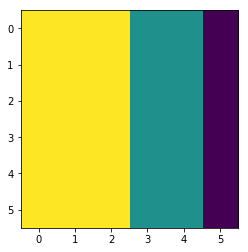

In [7]:
print(x[500])
plt.imshow(x[40].reshape(6,6))

In [227]:
def generate_data(x_dim):
    x_r = np.ndarray(shape=(x_dim,x_dim))
    step_x = random.randint(1,x_dim -2) 
    step_y = random.randint(1,x_dim - 2)
    for i in range(0,x_dim, step_x):
        for j in range(0,x_dim, step_y):
            #in every step generate a new random integer
            rand = random.randint(0,37)
            x_r[i:i+step_x,j:j+step_y] = rand 
    return x_r

In [3]:
def generate_randomly_data():
    reshaped_vec= []
    for i in range(30000):
        vec = generate_data(6)
        vec_t = np.transpose(vec)
        vec = vec.flatten()
        vec_t = vec_t.flatten()
        reshaped_vec.append(vec)
        reshaped_vec.append(vec_t)
    return np.array(reshaped_vec)

In [4]:
x = generate_randomly_data()


## Data split

In [8]:
## get the training index so it can be divided by the batch size so we won't have errors in training
if x.shape[0] % batch_size != 0:
    training_index = int(x.shape[0] / batch_size)*batch_size

In [9]:
x_train = x[0:training_index-1000,]
x_test = x[training_index-1000:training_index,]
x_train = x_train.astype('float32') / 36.
x_test = x_test.astype('float32') / 36.

## AutoEncoder Model

In [87]:
#Generate the latent representation vectors !!
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [88]:
def plot_results(models,

                 data,

                 batch_size=20,

                 model_name="vae"):

    encoder, decoder = models

    x_test, _ = data

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,batch_size=batch_size)
    x_decoded = decoder.predict(z_mean)
    
    combined_data = np.array([x_test,x_decoded])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)
    
    #Try with my own z_sample dimensions = (1, latent_dimension)!!!
    z_mean_test = np.array([[0,0,0,0,0,0,0,0,0,0]])
    x_decoded_test = decoder.predict(z_mean_test)
    print('x_decoded_test ', x_decoded_test)
    plt.imshow(x_decoded_test.reshape(DIM, DIM), cmap=plt.cm.hsv, vmin = _min, vmax = _max)
    
    n = 10  # how many digits we will display
    plt.figure(figsize=(40, 8))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(DIM, DIM), cmap=plt.cm.hsv, vmin = _min, vmax = _max)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_decoded[i].reshape(DIM, DIM), cmap=plt.cm.hsv, vmin = _min, vmax = _max)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [89]:
# VAE model = encoder + decoder

# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)

z_mean = Dense(latent_dim, name='z_mean')(x)

z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [90]:
# use reparameterization trick to push the sampling out as input

# note that "output_shape" isn't necessary with the TensorFlow backend

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [91]:
# instantiate encoder model

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

encoder.summary()

plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 36)           0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 13)           481         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           140         dense_22[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           140         dense_22[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [92]:
# build decoder model

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(original_dim, activation='sigmoid')(x)

In [93]:
# instantiate decoder model

decoder = Model(latent_inputs, outputs, name='decoder')

decoder.summary()

plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 13)                143       
_________________________________________________________________
dense_24 (Dense)             (None, 36)                504       
Total params: 647
Trainable params: 647
Non-trainable params: 0
_________________________________________________________________


In [94]:
# instantiate VAE model

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='vae_mlp')

## Training

In [95]:

models = (encoder, decoder)

data = (x_test, _)

reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim

kl_loss = beta*(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))

kl_loss = K.sum(kl_loss, axis=-1)

kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

vae.summary()

plot_model(vae,

           to_file='vae_mlp.png',

           show_shapes=True)

vae.fit(x_train,

        epochs=epochs,

        batch_size=batch_size,

        validation_data=(x_test, None))

vae.save_weights('vae_mlp_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 36)                0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  761       
_________________________________________________________________
decoder (Model)              (None, 36)                647       
Total params: 1,408
Trainable params: 1,408
Non-trainable params: 0
_________________________________________________________________
Train on 3520 samples, validate on 1000 samples
Epoch 1/100
3520/3520 [==============================] - 1s 319us/step - loss: 11.6617 - val_loss: 8.1180
Epoch 2/100
3520/3520 [==============================] - 0s 118us/step - loss: 6.8142 - val_loss: 7.6576
Epoch 3/100
3520/3520 [==============================] - 0s 119us/step - loss: 6.7173 - val_loss: 7.5167
Epoch 4/100
3520/3520 [=================

3520/3520 [==============================] - 0s 119us/step - loss: 6.3528 - val_loss: 7.0552
Epoch 72/100
3520/3520 [==============================] - 0s 138us/step - loss: 6.3525 - val_loss: 7.0586
Epoch 73/100
3520/3520 [==============================] - 1s 143us/step - loss: 6.3522 - val_loss: 7.0504
Epoch 74/100
3520/3520 [==============================] - 1s 146us/step - loss: 6.3517 - val_loss: 7.0543
Epoch 75/100
3520/3520 [==============================] - 0s 128us/step - loss: 6.3514 - val_loss: 7.0564
Epoch 76/100
3520/3520 [==============================] - 0s 125us/step - loss: 6.3510 - val_loss: 7.0522
Epoch 77/100
3520/3520 [==============================] - 0s 122us/step - loss: 6.3508 - val_loss: 7.0532
Epoch 78/100
3520/3520 [==============================] - 0s 124us/step - loss: 6.3504 - val_loss: 7.0511
Epoch 79/100
3520/3520 [==============================] - 0s 126us/step - loss: 6.3501 - val_loss: 7.0517
Epoch 80/100
3520/3520 [==============================] - 0

## Prediction

x_decoded_test  [[0.21949686 0.39069065 0.35306314 0.3586908  0.17460985 0.05299781
  0.39320374 0.4730194  0.43587437 0.47516754 0.29491848 0.06851693
  0.3079473  0.43171483 0.4790571  0.54296625 0.3847209  0.10007013
  0.18027598 0.29249623 0.31607476 0.37266248 0.26379785 0.0660468
  0.21857335 0.3524698  0.389866   0.46254516 0.28054103 0.08136403
  0.16265479 0.25632587 0.27648884 0.45318702 0.30538774 0.08995534]]


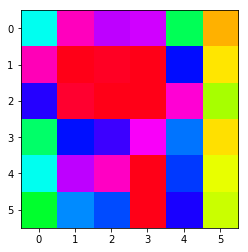

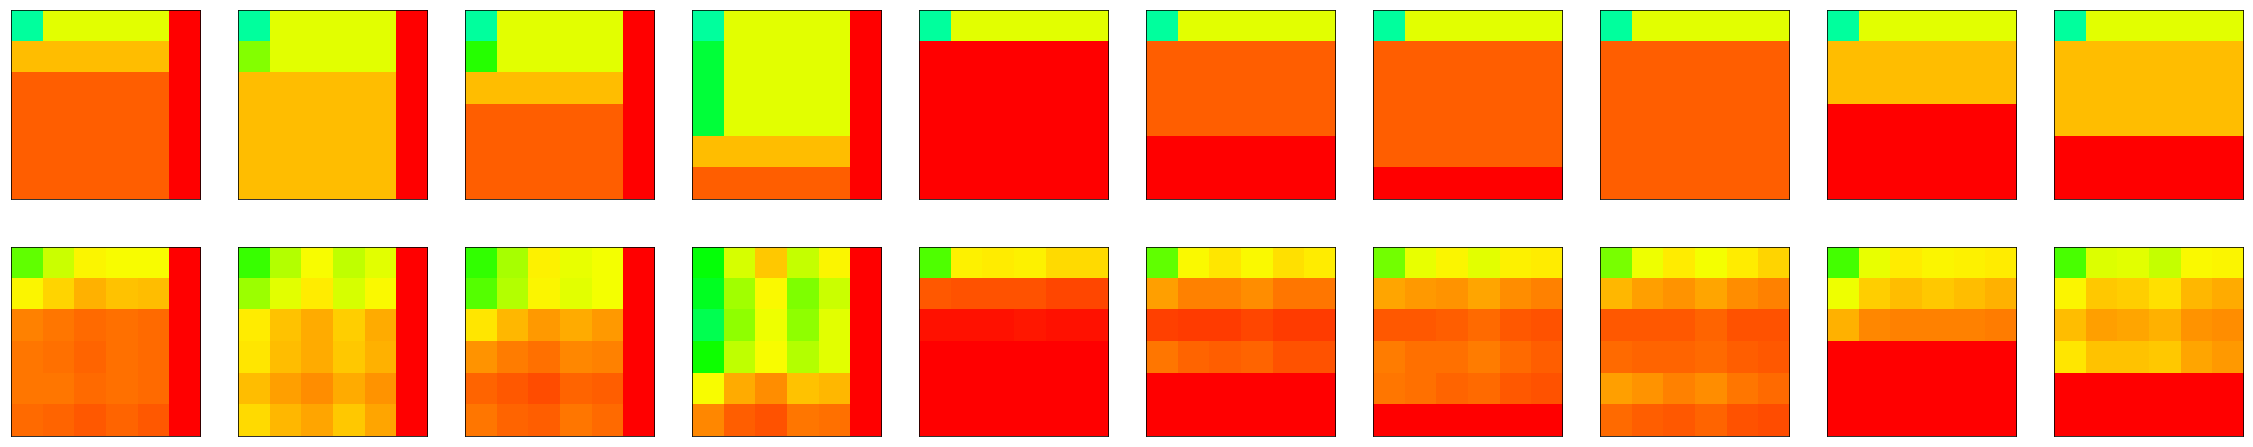

In [96]:
plot_results(models,

             data,

             batch_size=batch_size,
             model_name="vae_mlp")